#  load taxi data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import copy
import scipy.integrate as spi
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [2]:
data_taxi_fhv=pd.read_csv(r'C:\jupyter notebook\PAPER\data for taxi\fhv_tripdata_2020-03.csv')
data_taxi_fhvhv=pd.read_csv(r'C:\jupyter notebook\PAPER\data for taxi\fhvhv_tripdata_2020-03.csv')
data_taxi_green=pd.read_csv(r'C:\jupyter notebook\PAPER\data for taxi\green_tripdata_2020-03.csv')
data_taxi_yellow=pd.read_csv(r'C:\jupyter notebook\PAPER\data for taxi\yellow_tripdata_2020-03.csv')

data_taxi=pd.concat((data_taxi_fhv[['PULocationID','DOLocationID']],data_taxi_fhvhv[['PULocationID','DOLocationID']],data_taxi_green[['PULocationID','DOLocationID']],data_taxi_yellow[['PULocationID','DOLocationID']]),axis=0)
data_taxi=data_taxi.dropna().astype(int)
data_taxi['num']=1
data_taxi=data_taxi.reset_index(drop=True)
data_taxi 

,PULocationID,DOLocationID,num
0,264,264,1
1,264,264,1
2,264,264,1
3,264,264,1
4,264,264,1
...,...,...,...
17892296,137,87,1
17892297,137,71,1
17892298,137,32,1
17892299,137,159,1


In [3]:
data_zone=pd.read_csv(r'C:\jupyter notebook\PAPER\data for taxi\taxi zone look up table.csv')
data_zone

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


## It can be seen that there is no taxi orders in taxi zone 103,104. And taxi zone 264,265 are out of the five boroughs. Taxi zone 1 is the airport which are also out of these five boroughs. Thus, we delete these taxi zones.

In [4]:
def deal(r):
    if(r<103):
        return r-1
    else:
        return r-3

data_taxi=data_taxi[(data_taxi['PULocationID']!=264) & (data_taxi['PULocationID']!=265) & (data_taxi['PULocationID']!=1) &
          (data_taxi['DOLocationID']!=264) & (data_taxi['DOLocationID']!=265) & (data_taxi['DOLocationID']!=1)]

data_taxi['PULocationID']=data_taxi['PULocationID'].apply(lambda r:deal(r))
data_taxi['DOLocationID']=data_taxi['DOLocationID'].apply(lambda r:deal(r))
data_taxi=data_taxi.reset_index(drop=True)
data_taxi

,PULocationID,DOLocationID,num
0,55,170,1
1,170,170,1
2,55,170,1
3,55,126,1
4,55,55,1
...,...,...,...
16395289,134,86,1
16395290,134,70,1
16395291,134,31,1
16395292,134,156,1


In [5]:
data_zone=data_zone[(data_zone['LocationID']!=1) & (data_zone['LocationID']!=103) & (data_zone['LocationID']!=104) &
                    (data_zone['LocationID']!=264) & (data_zone['LocationID']!=265)]
data_zone=data_zone.reset_index(drop=True)
data_zone['LocationID']=data_zone['LocationID'].apply(lambda r:deal(r))
data_zone

,LocationID,Borough,Zone,service_zone
0,1,Queens,Jamaica Bay,Boro Zone
1,2,Bronx,Allerton/Pelham Gardens,Boro Zone
2,3,Manhattan,Alphabet City,Yellow Zone
3,4,Staten Island,Arden Heights,Boro Zone
4,5,Staten Island,Arrochar/Fort Wadsworth,Boro Zone
...,...,...,...,...
255,256,Bronx,Woodlawn/Wakefield,Boro Zone
256,257,Queens,Woodside,Boro Zone
257,258,Manhattan,World Trade Center,Yellow Zone
258,259,Manhattan,Yorkville East,Yellow Zone


In [6]:
data_taxi.to_csv('data_taxi.csv',index=False)
data_zone.to_csv('data_zone.csv',index=False)

# calculate the steady state distribution vector

In [7]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import copy
import scipy.integrate as spi
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

data_taxi=pd.read_csv('data_taxi.csv')
data_zone=pd.read_csv('data_zone.csv')
data_taxi

,PULocationID,DOLocationID,num
0,55,170,1
1,170,170,1
2,55,170,1
3,55,126,1
4,55,55,1
...,...,...,...
16395289,134,86,1
16395290,134,70,1
16395291,134,31,1
16395292,134,156,1


In [8]:
data_OD=data_taxi.groupby(['PULocationID','DOLocationID']).sum().unstack().fillna(0).astype(int)
data_OD=data_OD.applymap(lambda x:x+1)  
data_OD=np.array(data_OD).tolist()  

M=260

P=copy.deepcopy(data_OD)
for i in range(0,len(data_OD)):
    for j in range(0,len(data_OD)):
        P[i][j]=data_OD[i][j]/sum(data_OD[i])

A=copy.deepcopy(P)
for i in range(0,M):
    for j in range(0,M):
        if(i==j):
            A[i][j]=1-A[i][j]
        else:
            A[i][j]=-A[i][j]

def get_reset(array):
    L=[]
    for i in range(len(array)):
        array_copy=copy.deepcopy(array)
        for x in range(len(array_copy)):
            array_copy[i][x]=0
        for y in range(len(array_copy)):
            array_copy[y][i]=0
        array_copy[i][i]=1
        L.append(np.linalg.det(array_copy))
    return L
KU=get_reset(A)
PI=KU/sum(KU)
PI

array([1.95978777e-05, 2.39818346e-03, 2.97564252e-03, 2.87385597e-04,
       5.68536924e-04, 9.23184193e-03, 4.70334671e-05, 8.37227015e-04,
       2.69038216e-03, 1.15517900e-03, 1.86163398e-04, 4.20632333e-03,
       5.20236647e-03, 7.00395754e-04, 1.86110452e-03, 8.43016786e-03,
       5.80830619e-03, 5.99980594e-04, 3.29817373e-03, 2.64533850e-03,
       3.38619358e-03, 1.73580194e-03, 1.98939347e-03, 4.29852617e-03,
       5.86893257e-03, 6.89430371e-05, 2.09148958e-03, 2.19798154e-03,
       6.33801738e-05, 4.19893509e-04, 2.89297840e-03, 3.91121275e-03,
       8.07203337e-04, 6.69074214e-03, 6.88176136e-03, 1.02561719e-02,
       8.31534033e-04, 7.72383676e-03, 1.96365526e-03, 7.70944360e-03,
       1.04454733e-02, 3.01722837e-03, 4.73108001e-04, 1.90267640e-03,
       2.16137696e-04, 4.17634610e-03, 1.00010600e-02, 5.53015522e-03,
       5.91881187e-03, 4.00950010e-03, 1.16306335e-03, 1.44004846e-03,
       4.76096361e-04, 2.52228680e-03, 2.85227860e-03, 2.61728340e-04,
      

## the total pi of each borough

In [10]:
list_Queens=list(data_zone[data_zone['Borough']=='Queens']['LocationID'])
list_Bronx =list(data_zone[data_zone['Borough']=='Bronx']['LocationID'])
list_Brooklyn=list(data_zone[data_zone['Borough']=='Brooklyn']['LocationID'])
list_Manhattan=list(data_zone[data_zone['Borough']=='Manhattan']['LocationID'])
list_StatenIsland=list(data_zone[data_zone['Borough']=='Staten Island']['LocationID'])

def find_PI(List,PI_special):
    total=0
    for i in range(len(List)):
        total+=PI_special[List[i]-1]
    return total

PI_Queens=find_PI(list_Queens,PI)
PI_Bronx =find_PI(list_Bronx,PI)
PI_Brooklyn=find_PI(list_Brooklyn,PI)
PI_Manhattan=find_PI(list_Manhattan,PI)
PI_StatenIsland=find_PI(list_StatenIsland,PI)

PI_list=[PI_Bronx,PI_Brooklyn,PI_Manhattan,PI_Queens,PI_StatenIsland]
PI_list

[0.14750761166762946,
 0.2516349433696189,
 0.4051611157119344,
 0.17949524383073087,
 0.01620108542008648]

# load epidemic data

In [11]:
qaz=pd.read_csv(r'C:\jupyter notebook\PAPER\coronavirus-data-master\trends\data-by-day.csv')
qaz

,date_of_interest,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,PROBABLE_DEATH_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,...,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,SI_PROBABLE_DEATH_COUNT,SI_CASE_COUNT_7DAY_AVG,SI_PROBABLE_CASE_COUNT_7DAY_AVG,SI_ALL_CASE_COUNT_7DAY_AVG,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,SI_ALL_DEATH_COUNT_7DAY_AVG,INCOMPLETE
0,02/29/2020,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,03/01/2020,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,03/02/2020,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,03/03/2020,1,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,03/04/2020,5,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,11/19/2021,1124,361,37,8,0,1063,1406,37,7,...,2,0,0,92,21,113,3,1,1,11000
630,11/20/2021,766,276,37,9,0,1086,1436,37,7,...,2,0,0,96,21,117,3,1,1,11000
631,11/21/2021,810,292,26,4,0,1104,1456,37,7,...,3,0,0,99,21,120,3,0,1,11000
632,11/22/2021,1348,425,14,5,3,1120,1476,33,7,...,2,1,0,101,21,122,3,1,1,11000


In [13]:
data_convirus_cumsum=pd.read_csv(r'C:\jupyter notebook\PAPER\coronavirus-data-master\trends\data-by-day.csv')
data_convirus_cumsum=data_convirus_cumsum[['date_of_interest','CASE_COUNT','BX_CASE_COUNT','BK_CASE_COUNT','MN_CASE_COUNT','QN_CASE_COUNT','SI_CASE_COUNT']]
data_convirus_cumsum[['CASE_COUNT','BX_CASE_COUNT','BK_CASE_COUNT','MN_CASE_COUNT','QN_CASE_COUNT','SI_CASE_COUNT']]=data_convirus_cumsum[['CASE_COUNT','BX_CASE_COUNT','BK_CASE_COUNT','MN_CASE_COUNT','QN_CASE_COUNT','SI_CASE_COUNT']].cumsum()

data_death_cumsum=pd.read_csv(r'C:\jupyter notebook\PAPER\coronavirus-data-master\trends\deaths-by-day.csv')
data_death_cumsum=data_death_cumsum[['date_of_interest','DEATH_COUNT','BX_DEATH_COUNT','BK_DEATH_COUNT','MN_DEATH_COUNT','QN_DEATH_COUNT','SI_DEATH_COUNT']]
data_death_cumsum[['DEATH_COUNT','BX_DEATH_COUNT','BK_DEATH_COUNT','MN_DEATH_COUNT','QN_DEATH_COUNT','SI_DEATH_COUNT']]=data_death_cumsum[['DEATH_COUNT','BX_DEATH_COUNT','BK_DEATH_COUNT','MN_DEATH_COUNT','QN_DEATH_COUNT','SI_DEATH_COUNT']].cumsum()

data_convirus=copy.deepcopy(data_convirus_cumsum)
data_convirus['CASE_COUNT']=data_convirus_cumsum['CASE_COUNT']-data_death_cumsum['DEATH_COUNT']
data_convirus['BX_CASE_COUNT']=data_convirus_cumsum['BX_CASE_COUNT']-data_death_cumsum['BX_DEATH_COUNT']
data_convirus['BK_CASE_COUNT']=data_convirus_cumsum['BK_CASE_COUNT']-data_death_cumsum['BK_DEATH_COUNT']
data_convirus['MN_CASE_COUNT']=data_convirus_cumsum['MN_CASE_COUNT']-data_death_cumsum['MN_DEATH_COUNT']
data_convirus['QN_CASE_COUNT']=data_convirus_cumsum['QN_CASE_COUNT']-data_death_cumsum['QN_DEATH_COUNT']
data_convirus['SI_CASE_COUNT']=data_convirus_cumsum['SI_CASE_COUNT']-data_death_cumsum['SI_DEATH_COUNT']
data_convirus

,date_of_interest,CASE_COUNT,BX_CASE_COUNT,BK_CASE_COUNT,MN_CASE_COUNT,QN_CASE_COUNT,SI_CASE_COUNT
0,02/29/2020,1,0,0,1,0,0
1,03/01/2020,1,0,0,1,0,0
2,03/02/2020,1,0,0,1,0,0
3,03/03/2020,2,0,0,1,1,0
4,03/04/2020,7,0,1,3,3,0
...,...,...,...,...,...,...,...
629,11/19/2021,906721,166128,275462,133849,256598,74576
630,11/20/2021,907478,166194,275723,133982,256819,74652
631,11/21/2021,908284,166263,276011,134119,257039,74744
632,11/22/2021,909627,166395,276473,134389,257381,74881


# get the epidemic model and simulation

In [14]:
def funSIS(y,t,beta_R_D,beta_D_R,beta_R_R,gamma_R,gamma_D,M,N,ND,P,PI):
    Y=np.zeros(6*M)
    X=y
    K=ND/N
    
    for i in range(0,M):
        sum1=0
        for j in range(0,M):
            sum1+=P[j][i]*(X[j]*(1-beta_R_D*X[j+4*M]/PI[j]/N))#+gamma_D*X[j+M])
        Y[i]=sum1-X[i]
        
    for i in range(0,M):
        sum1=0
        for j in range(0,M):
            sum1+=P[j][i]*(X[j+M]*(1-gamma_D)+beta_R_D*X[j]*X[j+4*M]/PI[j]/N)
        Y[i+M]=sum1-X[i+M]
    
    for i in range(0,M):
        sum1=0
        for j in range(0,M):
            sum1+=P[j][i]*(X[j+2*M]+gamma_D*X[j+M])
        Y[i+2*M]=sum1-X[i+2*M]
                           
    for i in range(0,M):
        sum1=0
        for j in range(0,M):
            sum1+=P[j][i]*(X[j+3*M]*ND/N-beta_D_R*X[j+M]*X[j+3*M]/PI[j]/N)#+gamma_R*X[j+3*M]*ND/N)
        Y[i+3*M]=sum1-X[i+3*M]*ND/N-beta_R_R*X[i+3*M]*X[i+4*M]/PI[i]/N*(1-ND/N)#+gamma_R*X[i+3*M]*(1-ND/N)
    
    for i in range(0,M):
        sum1=0
        for j in range(0,M):
            sum1+=P[j][i]*(beta_D_R*X[j+M]*X[j+3*M]/PI[j]/N+X[j+4*M]*(1-gamma_R)*ND/N)
        Y[i+4*M]=sum1-X[i+4*M]*ND/N+beta_R_R*X[i+3*M]*X[i+4*M]*(1-ND/N)/PI[i]/N-gamma_R*X[i+4*M]*(1-ND/N)
    
    for i in range(0,M):
        sum1=0
        for j in range(0,M):
            sum1+=P[j][i]*(X[j+5*M]*ND/N+gamma_R*X[i+4*M]*(ND/N))
        Y[i+5*M]=sum1-X[i+5*M]*ND/N+gamma_R*X[i+4*M]*(1-ND/N)
    return Y

In [15]:
N = 8900000 # the total number of residents in NYC
ND=10000 # the total number of taxis in NYX
S_D_0=list(PI*ND) # S_D_0,I_D_0,S_R_0,I_R_0,R_R_0 are the inital state
I_D_0=[0]*M
R_D_0=[0]*M
S_R_0=list(N*PI)
I_R_0=[0]*M
R_R_0=[0]*M
S_R_0[0]=S_R_0[0]-1
I_R_0[0]=1
INI = S_D_0+I_D_0+R_D_0+S_R_0+I_R_0+R_R_0

t= np.linspace(1,200,200)
solution=spi.odeint(funSIS,INI,t,args=(0.192,0.192*1.5,0.192,0.07,0.07,M,N,ND,P,PI)) 

## the simulation in NYC and each borough

In [16]:
result_I=[]
for i in range(0,len(solution)):
    result_I.append(sum(solution[i][4*M:5*M])+sum(solution[i][M:2*M]))

result_I_Bronx=[]
for i in range(0,len(solution)):
    L1=list(solution[i][4*M:5*M])
    L2=list(solution[i][M:2*M])
    number=0
    for j in list_Bronx:
        number+=L1[j-1]
        number+=L2[j-1]
    result_I_Bronx.append(number)

result_I_Brooklyn=[]
for i in range(0,len(solution)):
    L1=list(solution[i][4*M:5*M])
    L2=list(solution[i][M:2*M])
    number=0
    for j in list_Brooklyn:
        number+=L1[j-1]
        number+=L2[j-1]
    result_I_Brooklyn.append(number)

result_I_Manhattan=[]
for i in range(0,len(solution)):
    L1=list(solution[i][4*M:5*M])
    L2=list(solution[i][M:2*M])
    number=0
    for j in list_Manhattan:
        number+=L1[j-1]
        number+=L2[j-1]
    result_I_Manhattan.append(number)

result_I_Queens=[]
for i in range(0,len(solution)):
    L1=list(solution[i][4*M:5*M])
    L2=list(solution[i][M:2*M])
    number=0
    for j in list_Queens:
        number+=L1[j-1]
        number+=L2[j-1]
    result_I_Queens.append(number)

result_I_StatenIsland=[]
for i in range(0,len(solution)):
    L1=list(solution[i][4*M:5*M])
    L2=list(solution[i][M:2*M])
    number=0
    for j in list_StatenIsland:
        number+=L1[j-1]
        number+=L2[j-1]
    result_I_StatenIsland.append(number)

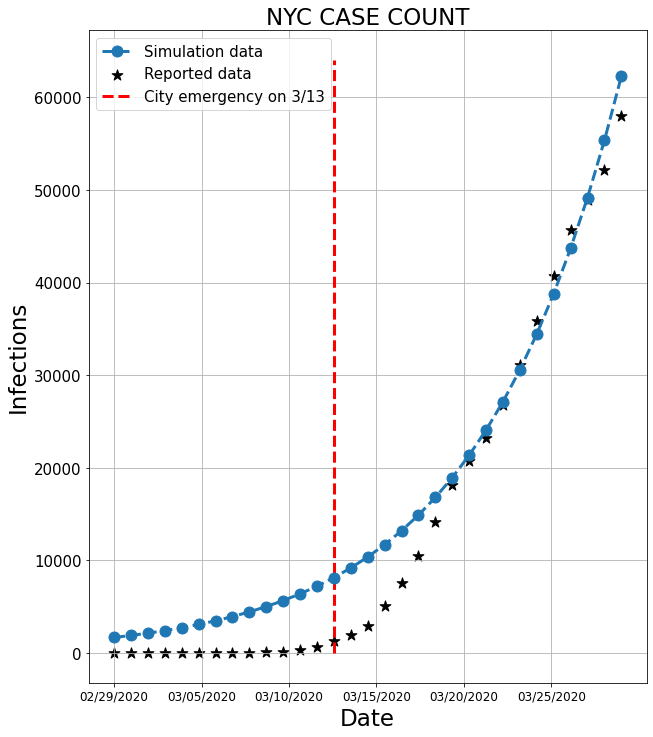

In [19]:
df1=data_convirus.iloc[:31]
df1['case_count']=result_I[85:116]
df1['bx_case_count']=result_I_Bronx[85:116]
df1['mn_case_count']=result_I_Manhattan[85:116]
df1['qn_case_count']=result_I_Queens[85:116]
df1['si_case_count']=result_I_StatenIsland[85:116]

plt.subplots(figsize=(10,12))

plt.plot(result_I[86:117],linestyle='--',marker='o',linewidth=3,markersize=11,label='Simulation data')
plt.scatter(np.linspace(0,30,31),df1['CASE_COUNT'].iloc[:31],marker='*',c='black',s=130,label='Reported data')

plt.title('NYC CASE COUNT',fontsize=23)
plt.xlabel('Date',fontsize=23)
plt.ylabel('Infections',fontsize=23)

my_tick=np.linspace(0,30,30)
my_label=list(data_convirus[:30]['date_of_interest'])

plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=15)
plt.vlines(13,0,64000,colors = "r", linestyles = "dashed",linewidth=3,label='City emergency on 3/13')
plt.legend(fontsize=15)
plt.grid(b=True)#,axis='x') 
plt.xticks(my_tick[::5],my_label[::5],rotation=0)

plt.savefig(r'the NYC case count.svg',dpi=1000,format='svg')

In [24]:
lines=[]
labels=[]
import matplotlib.gridspec as gridspec
plt.figure(figsize=(20,14),dpi=1000)
gs=gridspec.GridSpec(2,6)

ax1=plt.subplot(gs[0,:2])
plt.plot(result_I_Bronx[86:117],linestyle='--',marker='o',linewidth=3,markersize=11,label='Simulation data')
plt.scatter(np.linspace(0,30,31),data_convirus[:31].reset_index()['BX_CASE_COUNT'],marker='*',s=130,c='black',label='Reported data')
plt.title('Bronx',fontsize=26)
plt.ylabel('Infections',fontsize=23)
my_tick=np.linspace(0,30,31)
my_label=list(data_convirus[:30]['date_of_interest'])
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=18)
axLine, axLabel = ax1.get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
plt.xticks(my_tick[::13],my_label[::13],rotation=0)

ax2=plt.subplot(gs[0,2:4])
plt.plot(result_I_Brooklyn[86:117],linestyle='--',marker='o',linewidth=3,markersize=11,label='SIS data')
plt.scatter(np.linspace(0,30,31),data_convirus[:31].reset_index()['BK_CASE_COUNT'],marker='*',s=130,c='black',label='True data')
plt.title('Brooklyn',fontsize=26)
my_tick=np.linspace(0,30,30)
my_label=list(data_convirus[:30]['date_of_interest'])
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.xticks(my_tick[::13],my_label[::13],rotation=0)

ax3=plt.subplot(gs[0,4:])
plt.plot(result_I_Manhattan[86:117],linestyle='--',marker='o',linewidth=3,markersize=11,label='SIS data')
plt.scatter(np.linspace(0,30,31),data_convirus[:31].reset_index()['MN_CASE_COUNT'],marker='*',s=130,c='black',label='True data')
plt.title('Manhattan',fontsize=26)
my_tick=np.linspace(0,30,30)
my_label=list(data_convirus[:30]['date_of_interest'])
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.xticks(my_tick[::13],my_label[::13],rotation=0)

ax4=plt.subplot(gs[1,1:3])
plt.plot(result_I_Queens[86:117],linestyle='--',marker='o',linewidth=3,markersize=11,label='SIS data')
plt.scatter(np.linspace(0,30,31),data_convirus[:31].reset_index()['QN_CASE_COUNT'],marker='*',s=130,c='black',label='True data')
plt.title('Queens',fontsize=26)
plt.ylabel('Infections',fontsize=23)
my_tick=np.linspace(0,30,30)
my_label=list(data_convirus[:30]['date_of_interest'])
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.xticks(my_tick[::13],my_label[::13],rotation=0)

ax5=plt.subplot(gs[1,3:5])
plt.plot(result_I_StatenIsland[86:117],linestyle='--',marker='o',linewidth=3,markersize=11,label='SIS data')
plt.scatter(np.linspace(0,30,31),data_convirus[:31].reset_index()['SI_CASE_COUNT'],marker='*',s=130,c='black',label='True data')
plt.title('StatenIsland',fontsize=26)
my_tick=np.linspace(0,30,30)
my_label=list(data_convirus[:30]['date_of_interest'])
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.xticks(my_tick[::13],my_label[::13],rotation=0)

plt.legend(lines, labels, fontsize=22,ncol=3, bbox_to_anchor=(0.6, -0.1))
plt.tight_layout(w_pad=0.9)
plt.subplots_adjust(wspace=0.45)
plt.savefig(r'the borough case count.svg',dpi=1000,format='svg')
plt.show()